# Figure 1

- Notebook to make figure one
- Moved from old on 2020.01.10
- by Cascade Tuholske

#### Dependencies

In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import seaborn as sns
import glob

#### Make Data Function

In [15]:
def make_pdays(df_stats, df_pop):
    
    "Makes a dataframe with stats and population to calc people days"
    
    # Make Population Long Format
    pop_long = pd.wide_to_long(df_pop, stubnames = 'P', i = 'ID_HDC_G0', j = 'year')
    pop_long.reset_index(level=0, inplace=True)
    pop_long.reset_index(level=0, inplace=True)
    pop_long = pop_long.drop('Unnamed: 0', axis = 1)
    
    # Get Total Days 
    data = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
    pdays = pd.DataFrame()
    pdays['ID_HDC_G0'] = data['ID_HDC_G0']
    pdays['year'] = data['year']
    pdays['total_days'] = data['total_days']
    pdays['CTR_MN_NM'] = data['CTR_MN_NM']
    pdays['sub-region'] = data['sub-region']
    pdays['region'] = data['region']
    pdays['intermediate-region'] = data['intermediate-region']
    
    # Merge
    pdays_merge = pdays.merge(pop_long, on=['ID_HDC_G0', 'year'], how = 'left')

    # Now get people days from 1983 and change
    p = pd.DataFrame()
    p['ID_HDC_G0'] = df_pop['ID_HDC_G0']
    p['P1983'] = df_pop['P1983']
    p['P2016'] = df_pop['P2016']
#    p['p_delt'] = (df_pop['P2016'] - df_pop['P1983']) / df_pop['P1983'] * 100

    pdays_merge = pdays_merge.merge(p ,on=['ID_HDC_G0'], how = 'left')
    
    # Calc p days
    pdays_merge['people_days'] = pdays_merge['total_days'] * pdays_merge['P'] / 10**9 # total people days
    pdays_merge['people_days_83'] = pdays_merge['total_days'] * pdays_merge['P1983'] / 10**9 # people days w/ pop con
    pdays_merge['people_days_attr'] = pdays_merge['people_days'] - pdays_merge['people_days_83']  # dif
    
    return pdays_merge

#### LM Function

In [16]:
# Regressions, no intercept is needed because we're using SK LEARN HERE 

# Get Data

def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    lm = LinearRegression()
    model = lm.fit(X_year, Y_stats)
    coef = lm.coef_
    
    return coef


# Make Data

In [17]:
# file paths
DATA_IN = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FN_stats = 'heatrange/All_data20200109_406C_es_final.csv'
df_stats = pd.read_csv(DATA_IN+FN_stats)
# FIG_OUT = '/home/cascade/projects/figures/'

FN_pop = 'GHS-UCDB-Interp.csv'
df_pop = pd.read_csv(DATA_IN+FN_pop)

In [18]:
df_data = make_pdays(df_stats, df_pop)

In [19]:
df_data.head()

,ID_HDC_G0,year,total_days,CTR_MN_NM,sub-region,region,intermediate-region,P,P1983,P2016,people_days,people_days_83,people_days_attr
0,2784,1983,1,Germany,Western Europe,Europe,Western Europe,9.976361e+05,997636.118717,1.573652e+06,0.000998,0.000998,0.000000e+00
1,2784,2013,1,Germany,Western Europe,Europe,Western Europe,1.538112e+06,997636.118717,1.573652e+06,0.001538,0.000998,5.404756e-04
2,2833,1983,1,Germany,Western Europe,Europe,Western Europe,6.014093e+04,60140.932532,6.497856e+04,0.000060,0.000060,0.000000e+00
3,2833,1984,1,Germany,Western Europe,Europe,Western Europe,6.033127e+04,60140.932532,6.497856e+04,0.000060,0.000060,1.903325e-07
4,2833,1998,1,Germany,Western Europe,Europe,Western Europe,6.411484e+04,60140.932532,6.497856e+04,0.000064,0.000060,3.973904e-06


# Plots

Text(1.25, 0.8, '140m increase in \npeople days per year')

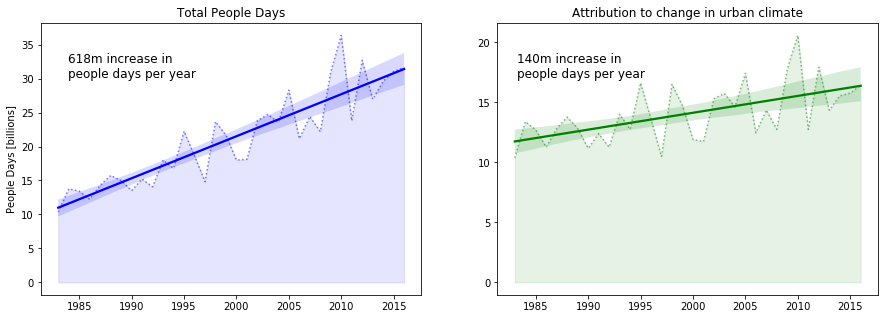

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (15,5), sharex=True)

# People Days
data = df_data.groupby('year')['people_days'].sum() 
years = list(data.index)
axs[0].plot(data, color = 'blue', linestyle = ':', alpha = 0.5)
axs[0].fill_between(years, data, color = 'blue', alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = 'blue', ax = axs[0], scatter = False, truncate = True)
axs[0].title.set_text('Total People Days')
axs[0].set_ylabel('People Days [billions]')

coef = int(lm_func(df_data, 'people_days')[0][0]*10**3)
axs[0].text(0.07, .8, str(coef)+'m increase in \npeople days per year', transform=axs[0].transAxes, 
            size=12)

# People Days
data = df_data.groupby('year')['people_days_83'].sum() 
years = list(data.index)
axs[1].plot(data, color = 'green', linestyle = ':', alpha = 0.5)
axs[1].fill_between(years, data, color = 'green', alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = 'green', ax = axs[1], scatter = False, truncate = True)
axs[1].title.set_text('Attribution to change in urban climate')
axs[1].set_ylabel('')

coef = int(lm_func(df_data, 'people_days_83')[0][0]*10**3)
axs[1].text(1.25, .8, str(coef)+'m increase in \npeople days per year', transform=axs[0].transAxes, 
            size=12)

# People Days
# data = df_data.groupby('year')['people_days_attr'].sum() 
# years = list(data.index)
# axs[2].plot(data, color = 'red', linestyle = ':', alpha = 0.5)
# axs[2].fill_between(years, data, color = 'red', alpha = 0.1, label='_nolegend_')
# sns.regplot(years, data, color = 'red', ax = axs[2], scatter = False, truncate = True)
# axs[2].title.set_text('Attribution to change in urban climate\n and population growth')
# axs[2].set_ylabel('')

# coef = int(lm_func(df_data, 'people_days_attr')[0][0]*10**3)
# axs[2].text(1.25*2-0.04, .8, str(coef)+'m increase in \npeople days per year', transform=axs[0].transAxes, 
#             size=12)

# Set y-axis
# for ax in fig.get_axes():
#     ax.label_outer()


# Title
# axs.set_title('Dayi * (Pi - P83)', fontsize = 20)
# axs.set_ylabel('Person Days [Billions]', fontsize = 20)
# axs.set_xlabel('Year', fontsize = 20)
# axs.tick_params(labelsize = 15)

# Regional plots

In [ ]:
# country level plots

country = 'Republic of Congo'
geog = 'CTR_MN_NM'
df_data[df_data[geog] == country]

# People Days
# fig, ax1 = plt.subplots(1, figsize = (15,5), sharex=True)
# data = df_data[df_data[geog] == country].groupby('year')['people_days'].sum() 
# data

#years = list(data.index)
#ax1.plot(data, color = 'blue', linestyle = ':', alpha = 0.5)



In [ ]:
region_list = []
coef_pdays = []
coef_pdays_83 = []

In [ ]:
for region in list(np.unique(df_data['sub-region'])):
    label = region
    region_list.append(label)
    
    df = df_data[df_data['sub-region'] == region]
    coef_pday = lm_func(df, 'people_days')[0][0]*10**9
    coef_pdays.append(coef_pday)
    
    df = df_data[df_data['sub-region'] == region]
    coef_pday = lm_func(df, 'people_days_83')[0][0]*10**9
    coef_pdays_83.append(coef_pday)

In [ ]:
fig, axs = plt.subplots(1, figsize = (10,10), sharex=True)

axs.scatter(coef_pdays, coef_pdays_83)
plt.xscale('log')
plt.yscale('log')
plt.xlim((1, 10**8))
plt.ylim((1, 10**8))